In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import sem
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))
from src.config import SESSION, N_LAYER
from palettable.scientific.sequential import Nuuk_3 as ColMap

SUBJECTS = ["p5"]#, "p2", "p3", "p4", "p5"]
DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"
SESS = "GE_EPI"
PART = "both"  # first | second | both
FILTER_SIZE = [0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0]

def get_profile(day, filter):
    y = np.zeros((N_LAYER, len(SUBJECTS)))
    yy = np.zeros((N_LAYER, len(SUBJECTS)))
    for i, subj in enumerate(SUBJECTS):
        path = Path(DIR_DATA) / subj / f"{SESS}{SESSION[subj][SESS][day]}"
        file = path / f"bandpass_{filter}" / "accuracy.csv"
        data = np.genfromtxt(file, delimiter=',')

        file2 = path / f"bandpass_none" / "accuracy.csv"
        data2 = np.genfromtxt(file2, delimiter=',')

        for j in range(N_LAYER):
            y[j, i] = np.mean(data[j, :] * 100)
            yy[j, i] = np.mean(data2[j, :] * 100)

    y = y/yy*100
    return y

data = np.zeros((len(FILTER_SIZE), N_LAYER))
for i, f in enumerate(FILTER_SIZE):
    y1 = get_profile(0, f)
    y2 = get_profile(1, f)
    y3 = np.append(y1, y2, axis=1)
    data[i, :] = np.mean(y3, axis=1)

#x = np.linspace(0, 1, N_LAYER)
#y1 = get_profile(0, 0.05)
#y2 = get_profile(1)
#y3 = np.append(y1, y2, axis=1)


In [2]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter
from palettable.scientific.sequential import Nuuk_3 as ColMap

nx = 1000
ny = 1000

# size of input array
data_size = np.shape(data)

# grid of input array
x = [0.9296334326946054, 1.4150774765146426, 1.7875717924913979, 2.101599027058178, 3.0724871146982524, 3.817475746651763, 4.445530215785323, 4.998857310906818, 7.169829073414797, 10.240046783482603]
y = np.linspace(0, 1, N_LAYER)
xgrid, ygrid = np.meshgrid(x, y)
xgrid = np.reshape(xgrid, np.size(xgrid))
ygrid = np.reshape(ygrid, np.size(ygrid))
xi_old = np.stack((xgrid, ygrid), 1)

# values of input array
data_array = np.zeros(len(xi_old))
c = 0
for i in range(N_LAYER):
    for j in range(len(FILTER_SIZE)):
        data_array[c] = data[j, i]
        c += 1

# grid of output array
x_new = np.linspace(0.95, 10.0, nx)
y_new = np.linspace(0, 1, ny)
xgrid_new, ygrid_new = np.meshgrid(x_new, y_new)
xgrid_new = np.reshape(xgrid_new, np.size(xgrid_new))
ygrid_new = np.reshape(ygrid_new, np.size(ygrid_new))
xi_new = np.stack((xgrid_new, ygrid_new), 1)

# grid values from old grid to new grid
data_array_new = griddata(xi_old, data_array, xi_new, method='linear')
data_array_new = np.reshape(data_array_new, (ny, nx))

data_array_filtered = data_array_new # gaussian_filter(data_array_new, 10.0)

/tmp/ipykernel_2120249/657380197.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


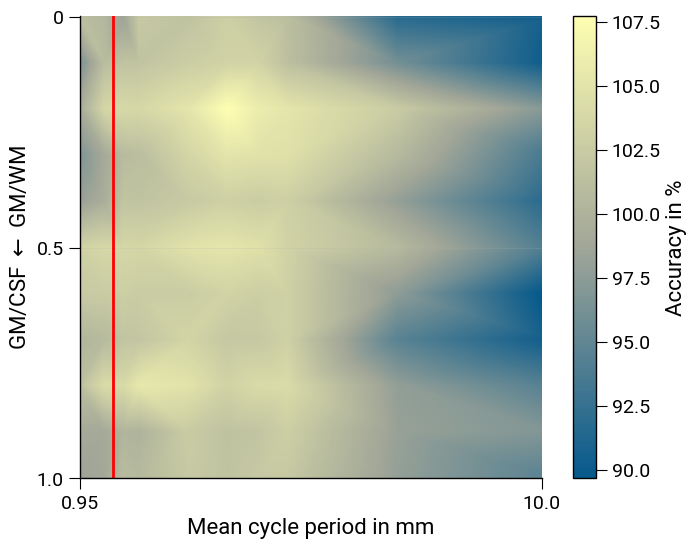

In [3]:
fig, ax = plt.subplots()
im = ax.imshow(data_array_filtered, cmap=ColMap.mpl_colormap)
#if SESS == "VASO":
#    cs = ax.contour(x_new, y_new, data_array_filtered, [54.0], colors="black", linewidths=0.3)  # vaso
#elif SESS == "GE_EPI":
#    cs = ax.contour(x_new, y_new, data_array_filtered, [80.0, 85.0], colors="black", linewidths=0.3)  # ge_epi
#elif SESS == "SE_EPI":
#    cs = ax.contour(x_new, y_new, data_array_filtered, [70.0, 75.0], colors="black", linewidths=0.3)  # se_epi
#ax.clabel(cs, inline=True, fontsize=10)
ax.set_yticks([0, 500, 1000], [0,0.5,1.0])
ax.set_xticks([0, 1000], [0.95, 10.0])
ax.set_ylabel(r"GM/CSF $\leftarrow$ GM/WM")
ax.set_xlabel("Mean cycle period in mm")
ax.axvline(72, color="red")
cbar = plt.colorbar(im)
cbar.set_label("Accuracy in %")
file_out = f"/data/pt_01880/n_features_{SESS}.svg"
#fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")

# veränderung zum ungefilterten

In [283]:
x_new[72]

1.6022522522522522

In [ ]:

fig, ax = plt.subplots()
color = ColMap.hex_colors
if PART == "first":
    ax.plot(x, np.mean(y1, axis=1), color="gray", linestyle="-", label="Mean across subjects (first session)")
    ax.fill_between(x, np.mean(y1, axis=1)-sem(y1, axis=1), np.mean(y1, axis=1)+sem(y1, axis=1), color="gray", alpha=0.1, lw=0)
elif PART == "second":
    ax.plot(x, np.mean(y2, axis=1), color="gray", linestyle="--", label="Mean across subjects (second session)")
    ax.fill_between(x, np.mean(y2, axis=1)-sem(y2, axis=1), np.mean(y2, axis=1)+sem(y2, axis=1), color="gray", alpha=0.1, lw=0)
elif PART == "both":
    ax.plot(x, np.mean(y1, axis=1), color="gray", linestyle="-", label="Mean across subjects (first session)")
    ax.plot(x, np.mean(y2, axis=1), color="gray", linestyle="--", label="Mean across subjects (second session)")
    ax.plot(x, np.mean(y3, axis=1), color=color[0], linestyle="-", label="Mean across subjects (both sessions)")
    ax.fill_between(x, np.mean(y3, axis=1)-sem(y3, axis=1), np.mean(y3, axis=1)+sem(y3, axis=1), color=color[0], alpha=0.1, lw=0)
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
ax.set_ylabel("Accuracy in %")
ax.legend(loc="lower right")
file_out = f"/data/pt_01880/decoding_{SESS}_{PART}.svg"
fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")

### Number of features

/tmp/ipykernel_758965/338662425.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


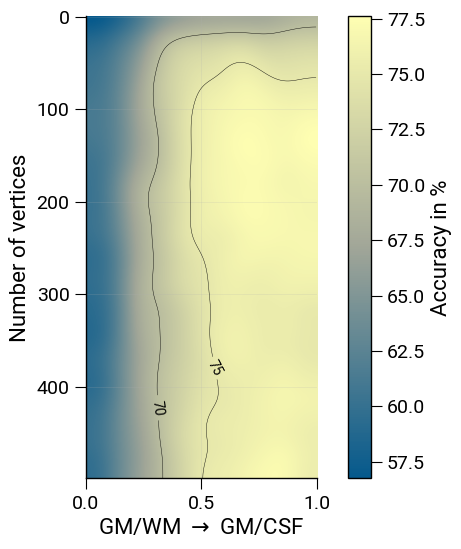

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import sem
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter
from palettable.scientific.sequential import Nuuk_3 as ColMap
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))
from src.config import SESSION, N_LAYER


SUBJECTS = ["p1", "p2", "p3", "p4", "p5"]
DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/n_features"
SESS = "SE_EPI"
FILTER_SIZE = "none"

def get_profile(day):
    y = np.zeros((N_LAYER, len(SUBJECTS)))
    for i, subj in enumerate(SUBJECTS):
        path = Path(DIR_DATA) / subj / f"{SESS}{SESSION[subj][SESS][day]}"
        file = path / "accuracy.csv"
        data = np.genfromtxt(file, delimiter=',')
    return data

z1 = get_profile(0)
z2 = get_profile(1)
z3 = (z1+z2)/2
dim1, dim2 = 500, 250
x, y = np.meshgrid(np.arange(dim2), np.arange(dim1))
z3_resized = resize(z3,(dim1,dim2))
z3_filtered = gaussian_filter(z3_resized, 14.0)
z3_filtered *= 100

fig, ax = plt.subplots()
im = ax.imshow(z3_filtered, cmap=ColMap.mpl_colormap)
if SESS == "VASO":
    cs = ax.contour(x, y, z3_filtered, [55.0, 57.0], colors="black", linewidths=0.3)  # vaso
elif SESS == "GE_EPI":
    cs = ax.contour(x, y, z3_filtered, [80.0, 85.0], colors="black", linewidths=0.3)  # ge_epi
elif SESS == "SE_EPI":
    cs = ax.contour(x, y, z3_filtered, [70.0, 75.0], colors="black", linewidths=0.3)  # se_epi
ax.clabel(cs, inline=True, fontsize=10)
ax.set_xticks([0, 125, 250], [0.0, 0.5, 1.0])
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
ax.set_ylabel("Number of vertices")
cbar = plt.colorbar(im)
cbar.set_label("Accuracy in %")
file_out = f"/data/pt_01880/n_features_{SESS}.svg"
fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")